In [23]:
import datapackage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from keras import Sequential
from keras.layers import Dense
from keras.regularizers import l1, l2

In [2]:
#Import data

data_url = 'https://datahub.io/machine-learning/credit-approval/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        df = pd.read_csv(resource.descriptor['path'])

#### Target Class 

In [3]:
#Replace target class with 1 and 0
tar_rep = {'+':1,'-':0}
df['class'].replace(tar_rep,inplace=True)

<AxesSubplot:xlabel='class', ylabel='count'>

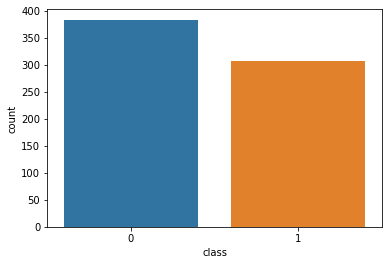

In [4]:
sns.countplot(data=df,x='class')

Sufficient samples from both classes

#### Nulls

In [5]:
#Check nulls

df.isnull().sum()

A1       12
A2       12
A3        0
A4        6
A5        6
A6        9
A7        9
A8        0
A9        0
A10       0
A11       0
A12       0
A13       0
A14      13
A15       0
class     0
dtype: int64

In [6]:
#Check total null rows

null_rows = len(df[df.isnull().any(axis=1)])

print("{} of rows is null".format(null_rows/len(df)))

0.0536231884057971 of rows is null


In [7]:
#Nulls in positive class
len(df[(df.isnull().any(axis=1)) & (df['class'] == 1)])

11

In [8]:
#Nulls in negative class
len(df[(df.isnull().any(axis=1)) & (df['class'] == 0)])

26

Since this is a small % of the data it could be dropped.

In [9]:
df.dropna(inplace=True)

#### Categoricals

In [10]:
#Replace categorical columns with dummies

cat_cols = list(df.select_dtypes(include=['object']).columns)

df = pd.get_dummies(df,columns=cat_cols,drop_first=True)

### Neural Network

In [11]:
#Create input and target
X = df.drop(columns='class')
y= np.array(df['class'])

#standardizing the input feature
sc = StandardScaler()
X = sc.fit_transform(X)

#### N/3

In [12]:
# Define per-fold score containers
loss_per_fold = []
acc_per_fold=[]
sklearn_f1=[]

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X,y):

    #Build NN
    
    classifier = Sequential()
    #First Hidden Layer
    classifier.add(Dense(round(X.shape[1]/3), activation='relu', kernel_initializer='random_normal', input_dim=X.shape[1]))
    #Output Layer
    classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    
    #Compiling the neural network
    classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    
    print('------------------------------------------------------------------------------')
    
    #Fitting the data to the training dataset
    history = classifier.fit(X[train],y[train], batch_size=10, epochs=25)
    
    #Use sklearn to calculate f1-score
    y_pred = classifier.predict(X[test])
    sklearn_f1.append(f1_score(y[test],y_pred.round()))
    
    # Generate generalization metrics
    scores = classifier.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {classifier.metrics_names[0]} of {scores[0]}; {classifier.metrics_names[1]} of {scores[1]};')
    loss_per_fold.append(scores[0])
    acc_per_fold.append(scores[1])
    
    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------------
Epoch 1/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6831 - accuracy: 0.6226
Epoch 2/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6415 - accuracy: 0.7778
Epoch 3/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5610 - accuracy: 0.8295
Epoch 4/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4720 - accuracy: 0.8372
Epoch 5/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4058 - accuracy: 0.8563
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3656 - accuracy: 0.8640
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3400 - accuracy: 0.8640
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3236 - accuracy: 0.8697
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3112 - accuracy: 0.8678
Epoch 10/25
53/53 [====================

53/53 [==============================] - 0s 1ms/step - loss: 0.6788 - accuracy: 0.7323
Epoch 2/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6336 - accuracy: 0.8317
Epoch 3/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5449 - accuracy: 0.8394
Epoch 4/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4507 - accuracy: 0.8489
Epoch 5/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3886 - accuracy: 0.8681
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3519 - accuracy: 0.8776
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3285 - accuracy: 0.8853
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3138 - accuracy: 0.8853
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3030 - accuracy: 0.8853
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2953 - accuracy: 0.8872
Epoch 11/25
53/53 [===========

In [13]:
print(f'The average f1- score over 5- fold cross validation is {np.mean(sklearn_f1)}')

The average f1- score over 5- fold cross validation is 0.8420891099028441


#### N/2

In [14]:
# Define per-fold score containers
loss_per_fold = []
acc_per_fold=[]
sklearn_f1=[]

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X,y):

    #Build NN
    
    classifier = Sequential()
    #First Hidden Layer
    classifier.add(Dense(round(X.shape[1]/2), activation='relu', kernel_initializer='random_normal', input_dim=X.shape[1]))
    #Output Layer
    classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    
    #Compiling the neural network
    classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    
    print('------------------------------------------------------------------------------')
    
    #Fitting the data to the training dataset
    history = classifier.fit(X[train],y[train], batch_size=10, epochs=25)
    
    #Use sklearn to calculate f1-score
    y_pred = classifier.predict(X[test])
    sklearn_f1.append(f1_score(y[test],y_pred.round()))
    
    # Generate generalization metrics
    scores = classifier.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {classifier.metrics_names[0]} of {scores[0]}; {classifier.metrics_names[1]} of {scores[1]};')
    loss_per_fold.append(scores[0])
    acc_per_fold.append(scores[1])
    
    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------------
Epoch 1/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6787 - accuracy: 0.6935
Epoch 2/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6143 - accuracy: 0.8103
Epoch 3/25
53/53 [==============================] - 0s 2ms/step - loss: 0.5036 - accuracy: 0.8238
Epoch 4/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4095 - accuracy: 0.8467
Epoch 5/25
53/53 [==============================] - 0s 2ms/step - loss: 0.3564 - accuracy: 0.8602
Epoch 6/25
53/53 [==============================] - 0s 2ms/step - loss: 0.3249 - accuracy: 0.8716
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3051 - accuracy: 0.8793
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2915 - accuracy: 0.8831
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2811 - accuracy: 0.8851
Epoch 10/25
53/53 [====================

53/53 [==============================] - 0s 1ms/step - loss: 0.6823 - accuracy: 0.6616
Epoch 2/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6230 - accuracy: 0.8489
Epoch 3/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5142 - accuracy: 0.8585
Epoch 4/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4183 - accuracy: 0.8642
Epoch 5/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3633 - accuracy: 0.8719
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3339 - accuracy: 0.8738
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3147 - accuracy: 0.8834
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3025 - accuracy: 0.8853
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2924 - accuracy: 0.8853
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2844 - accuracy: 0.8910
Epoch 11/25
53/53 [===========

In [15]:
print(f'The average f1- score over 5- fold cross validation is {np.mean(sklearn_f1)}')

The average f1- score over 5- fold cross validation is 0.8602794374917305


#### N-1

In [16]:
# Define per-fold score containers
loss_per_fold = []
acc_per_fold=[]
sklearn_f1=[]

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X,y):

    #Build NN
    
    classifier = Sequential()
    #First Hidden Layer
    classifier.add(Dense(X.shape[1]-1, activation='relu', kernel_initializer='random_normal', input_dim=X.shape[1]))
    #Output Layer
    classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    
    #Compiling the neural network
    classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    
    print('------------------------------------------------------------------------------')
    
    #Fitting the data to the training dataset
    history = classifier.fit(X[train],y[train], batch_size=10, epochs=25)
    
    #Use sklearn to calculate f1-score
    y_pred = classifier.predict(X[test])
    sklearn_f1.append(f1_score(y[test],y_pred.round()))
    
    # Generate generalization metrics
    scores = classifier.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {classifier.metrics_names[0]} of {scores[0]}; {classifier.metrics_names[1]} of {scores[1]};')
    loss_per_fold.append(scores[0])
    acc_per_fold.append(scores[1])
    
    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------------
Epoch 1/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6611 - accuracy: 0.7490
Epoch 2/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5574 - accuracy: 0.8161
Epoch 3/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4367 - accuracy: 0.8352
Epoch 4/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3687 - accuracy: 0.8544
Epoch 5/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3335 - accuracy: 0.8659
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3104 - accuracy: 0.8793
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2975 - accuracy: 0.8831
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2853 - accuracy: 0.8831
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2774 - accuracy: 0.8851
Epoch 10/25
53/53 [====================

53/53 [==============================] - 0s 1ms/step - loss: 0.6692 - accuracy: 0.7094
Epoch 2/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5612 - accuracy: 0.8337
Epoch 3/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4215 - accuracy: 0.8509
Epoch 4/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3433 - accuracy: 0.8585
Epoch 5/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3082 - accuracy: 0.8719
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2875 - accuracy: 0.8795
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2739 - accuracy: 0.8834
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2651 - accuracy: 0.8853
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2590 - accuracy: 0.8853
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2535 - accuracy: 0.8891
Epoch 11/25
53/53 [===========

In [17]:
print(f'The average f1- score over 5- fold cross validation is {np.mean(sklearn_f1)}')

The average f1- score over 5- fold cross validation is 0.838914544702025


#### N-1, N/2+3

In [20]:
# Define per-fold score containers
loss_per_fold = []
acc_per_fold=[]
sklearn_f1=[]

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X,y):

    #Build NN
    
    classifier = Sequential()
    #First Hidden Layer
    classifier.add(Dense(X.shape[1]-1, activation='relu', kernel_initializer='random_normal', input_dim=X.shape[1]))
    #Second Hidden Layer
    classifier.add(Dense(round(X.shape[1]/2+3), activation='relu', kernel_initializer='random_normal'))
    #Output Layer
    classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    
    #Compiling the neural network
    classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    
    print('------------------------------------------------------------------------------')
    
    #Fitting the data to the training dataset
    history = classifier.fit(X[train],y[train], batch_size=10, epochs=25)
    
    #Use sklearn to calculate f1-score
    y_pred = classifier.predict(X[test])
    sklearn_f1.append(f1_score(y[test],y_pred.round()))
    
    # Generate generalization metrics
    scores = classifier.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {classifier.metrics_names[0]} of {scores[0]}; {classifier.metrics_names[1]} of {scores[1]};')
    loss_per_fold.append(scores[0])
    acc_per_fold.append(scores[1])
    
    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------------
Epoch 1/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6832 - accuracy: 0.7471
Epoch 2/25
53/53 [==============================] - 0s 2ms/step - loss: 0.5643 - accuracy: 0.8238
Epoch 3/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3700 - accuracy: 0.8582
Epoch 4/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3232 - accuracy: 0.8716
Epoch 5/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3019 - accuracy: 0.8831
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2881 - accuracy: 0.8870
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2827 - accuracy: 0.8870
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2782 - accuracy: 0.8889
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2650 - accuracy: 0.9023
Epoch 10/25
53/53 [====================

53/53 [==============================] - 0s 1ms/step - loss: 0.6817 - accuracy: 0.5851
Epoch 2/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5667 - accuracy: 0.8088
Epoch 3/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3792 - accuracy: 0.8451
Epoch 4/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3100 - accuracy: 0.8757
Epoch 5/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2828 - accuracy: 0.8853
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2669 - accuracy: 0.8929
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2556 - accuracy: 0.9006
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2460 - accuracy: 0.8987
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2376 - accuracy: 0.9082
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.2309 - accuracy: 0.9120
Epoch 11/25
53/53 [===========

In [21]:
print(f'The average f1- score over 5- fold cross validation is {np.mean(sklearn_f1)}')

The average f1- score over 5- fold cross validation is 0.8339267042935596


The best performing network is the one with a single hidden layer and N/2 neurons.

#### Applying L1 regularization on N/2 neuron network

In [26]:
#Lambda range
lambda_val = [0.001,0.002,0.005,0.01,0.05,0.1]
lam_cont=[]

for lam in lambda_val:

    # Define per-fold score containers
    loss_per_fold = []
    acc_per_fold=[]
    sklearn_f1=[]
    
    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=5, shuffle=True)
    
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(X,y):
    
        #Build NN
        
        classifier = Sequential()
        #First Hidden Layer
        classifier.add(Dense(round(X.shape[1]/2), activation='relu',kernel_regularizer=l1(lam), bias_regularizer=l1(lam),input_dim=X.shape[1]))
        #Output Layer
        classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
        
        #Compiling the neural network
        classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
        
        print('------------------------------------------------------------------------------')
        
        #Fitting the data to the training dataset
        history = classifier.fit(X[train],y[train], batch_size=10, epochs=25)
        
        #Use sklearn to calculate f1-score
        y_pred = classifier.predict(X[test])
        sklearn_f1.append(f1_score(y[test],y_pred.round()))
        
        # Generate generalization metrics
        scores = classifier.evaluate(X[test], y[test], verbose=0)
        print(f'Score for fold {fold_no}: {classifier.metrics_names[0]} of {scores[0]}; {classifier.metrics_names[1]} of {scores[1]};')
        loss_per_fold.append(scores[0])
        acc_per_fold.append(scores[1])
        
        # Increase fold number
        fold_no = fold_no + 1
        
    lam_cont.append({
        'Lambda':lam,
        'Avg f1-score':np.mean(sklearn_f1)
    })

------------------------------------------------------------------------------
Epoch 1/25
53/53 [==============================] - 0s 2ms/step - loss: 0.7821 - accuracy: 0.6130
Epoch 2/25
53/53 [==============================] - 0s 1ms/step - loss: 0.7292 - accuracy: 0.7644
Epoch 3/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6612 - accuracy: 0.8218
Epoch 4/25
53/53 [==============================] - 0s 2ms/step - loss: 0.5778 - accuracy: 0.8429
Epoch 5/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5037 - accuracy: 0.8506
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4520 - accuracy: 0.8640
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4176 - accuracy: 0.8793
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3948 - accuracy: 0.8831
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3790 - accuracy: 0.8908
Epoch 10/25
53/53 [====================

53/53 [==============================] - 0s 1ms/step - loss: 0.7786 - accuracy: 0.6119
Epoch 2/25
53/53 [==============================] - 0s 1ms/step - loss: 0.7152 - accuracy: 0.8011
Epoch 3/25
53/53 [==============================] - 0s 2ms/step - loss: 0.6409 - accuracy: 0.8279
Epoch 4/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5656 - accuracy: 0.8375
Epoch 5/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5031 - accuracy: 0.8470
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4580 - accuracy: 0.8604
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4251 - accuracy: 0.8719
Epoch 8/25
53/53 [==============================] - 0s 884us/step - loss: 0.4019 - accuracy: 0.8757
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3835 - accuracy: 0.8834
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3700 - accuracy: 0.8834
Epoch 11/25
53/53 [=========

53/53 [==============================] - 0s 1ms/step - loss: 0.8279 - accuracy: 0.7414
Epoch 3/25
53/53 [==============================] - 0s 1ms/step - loss: 0.7518 - accuracy: 0.8448
Epoch 4/25
53/53 [==============================] - 0s 2ms/step - loss: 0.6686 - accuracy: 0.8467
Epoch 5/25
53/53 [==============================] - 0s 2ms/step - loss: 0.5927 - accuracy: 0.8506
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5313 - accuracy: 0.8621
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4866 - accuracy: 0.8774
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4547 - accuracy: 0.8793
Epoch 9/25
53/53 [==============================] - 0s 2ms/step - loss: 0.4310 - accuracy: 0.8812
Epoch 10/25
53/53 [==============================] - 0s 2ms/step - loss: 0.4126 - accuracy: 0.8851
Epoch 11/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3999 - accuracy: 0.8889
Epoch 12/25
53/53 [==========

53/53 [==============================] - 0s 1ms/step - loss: 0.6891 - accuracy: 0.8509
Epoch 4/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6049 - accuracy: 0.8623
Epoch 5/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5356 - accuracy: 0.8757
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4846 - accuracy: 0.8795
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4485 - accuracy: 0.8834
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4232 - accuracy: 0.8815
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4043 - accuracy: 0.8853
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3894 - accuracy: 0.8967
Epoch 11/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3771 - accuracy: 0.8967
Epoch 12/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3677 - accuracy: 0.9006
Epoch 13/25
53/53 [=========

53/53 [==============================] - 0s 1ms/step - loss: 0.7765 - accuracy: 0.8621
Epoch 5/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6723 - accuracy: 0.8793
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5900 - accuracy: 0.8755
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5308 - accuracy: 0.8716
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4917 - accuracy: 0.8774
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4654 - accuracy: 0.8793
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4484 - accuracy: 0.8774
Epoch 11/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4352 - accuracy: 0.8793
Epoch 12/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4265 - accuracy: 0.8774
Epoch 13/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4175 - accuracy: 0.8831
Epoch 14/25
53/53 [========

53/53 [==============================] - 0s 1ms/step - loss: 0.7971 - accuracy: 0.8506
Epoch 6/25
53/53 [==============================] - 0s 939us/step - loss: 0.6800 - accuracy: 0.8659
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5995 - accuracy: 0.8697
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5472 - accuracy: 0.8640
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5107 - accuracy: 0.8793
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4839 - accuracy: 0.8831
Epoch 11/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4637 - accuracy: 0.8774
Epoch 12/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4475 - accuracy: 0.8851
Epoch 13/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4357 - accuracy: 0.8812
Epoch 14/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4268 - accuracy: 0.8793
Epoch 15/25
53/53 [=====

53/53 [==============================] - 0s 1ms/step - loss: 0.6567 - accuracy: 0.8757
Epoch 7/25
53/53 [==============================] - 0s 941us/step - loss: 0.5781 - accuracy: 0.8834
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5280 - accuracy: 0.8757
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4920 - accuracy: 0.8776
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4675 - accuracy: 0.8757
Epoch 11/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4516 - accuracy: 0.8757
Epoch 12/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4406 - accuracy: 0.8757
Epoch 13/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4328 - accuracy: 0.8757
Epoch 14/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4269 - accuracy: 0.8757
Epoch 15/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4214 - accuracy: 0.8757
Epoch 16/25
53/53 [====

53/53 [==============================] - 0s 1ms/step - loss: 0.6996 - accuracy: 0.5594
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5575
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6930 - accuracy: 0.5575
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.5575
Epoch 11/25
53/53 [==============================] - 0s 936us/step - loss: 0.6925 - accuracy: 0.5575
Epoch 12/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5575
Epoch 13/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6922 - accuracy: 0.5575
Epoch 14/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6921 - accuracy: 0.5575
Epoch 15/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6920 - accuracy: 0.5575
Epoch 16/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6919 - accuracy: 0.5575
Epoch 17/25
53/53 [===

53/53 [==============================] - 0s 1ms/step - loss: 0.6936 - accuracy: 0.5526
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5526
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5526
Epoch 11/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6929 - accuracy: 0.5526
Epoch 12/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6929 - accuracy: 0.5526
Epoch 13/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6927 - accuracy: 0.5526
Epoch 14/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.5526
Epoch 15/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.5526
Epoch 16/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5526
Epoch 17/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6923 - accuracy: 0.5526
Epoch 18/25
53/53 [====

53/53 [==============================] - 0s 1ms/step - loss: 0.6997 - accuracy: 0.5364
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6996 - accuracy: 0.5364
Epoch 11/25
53/53 [==============================] - 0s 953us/step - loss: 0.6995 - accuracy: 0.5364
Epoch 12/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6997 - accuracy: 0.5364
Epoch 13/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6996 - accuracy: 0.5364
Epoch 14/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6994 - accuracy: 0.5364
Epoch 15/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6993 - accuracy: 0.5364
Epoch 16/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6994 - accuracy: 0.5364
Epoch 17/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6993 - accuracy: 0.5364
Epoch 18/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6992 - accuracy: 0.5364
Epoch 19/25
53/53 [=

In [29]:
pd.DataFrame(lam_cont)

,Lambda,Avg f1-score
0,0.001,0.841655
1,0.002,0.860676
2,0.005,0.860111
3,0.010,0.862873
4,0.050,0.179310
5,0.100,0.000000


#### Applying L2 regularization on the N/2 neuron network

In [30]:
#Lambda range
lambda_val = [0.001,0.002,0.005,0.01,0.05,0.1]
lam_cont=[]

for lam in lambda_val:

    # Define per-fold score containers
    loss_per_fold = []
    acc_per_fold=[]
    sklearn_f1=[]
    
    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=5, shuffle=True)
    
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(X,y):
    
        #Build NN
        
        classifier = Sequential()
        #First Hidden Layer
        classifier.add(Dense(round(X.shape[1]/2), activation='relu',kernel_regularizer=l2(lam), bias_regularizer=l2(lam),input_dim=X.shape[1]))
        #Output Layer
        classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
        
        #Compiling the neural network
        classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
        
        print('------------------------------------------------------------------------------')
        
        #Fitting the data to the training dataset
        history = classifier.fit(X[train],y[train], batch_size=10, epochs=25)
        
        #Use sklearn to calculate f1-score
        y_pred = classifier.predict(X[test])
        sklearn_f1.append(f1_score(y[test],y_pred.round()))
        
        # Generate generalization metrics
        scores = classifier.evaluate(X[test], y[test], verbose=0)
        print(f'Score for fold {fold_no}: {classifier.metrics_names[0]} of {scores[0]}; {classifier.metrics_names[1]} of {scores[1]};')
        loss_per_fold.append(scores[0])
        acc_per_fold.append(scores[1])
        
        # Increase fold number
        fold_no = fold_no + 1
        
    lam_cont.append({
        'Lambda':lam,
        'Avg f1-score':np.mean(sklearn_f1)
    })

------------------------------------------------------------------------------
Epoch 1/25
53/53 [==============================] - 1s 878us/step - loss: 0.7004 - accuracy: 0.5900
Epoch 2/25
53/53 [==============================] - 0s 1ms/step - loss: 0.6458 - accuracy: 0.7625
Epoch 3/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5846 - accuracy: 0.8142
Epoch 4/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5175 - accuracy: 0.8218
Epoch 5/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4628 - accuracy: 0.8352
Epoch 6/25
53/53 [==============================] - 0s 2ms/step - loss: 0.4231 - accuracy: 0.8467
Epoch 7/25
53/53 [==============================] - 0s 2ms/step - loss: 0.3965 - accuracy: 0.8544
Epoch 8/25
53/53 [==============================] - 0s 2ms/step - loss: 0.3771 - accuracy: 0.8602
Epoch 9/25
53/53 [==============================] - 0s 2ms/step - loss: 0.3619 - accuracy: 0.8602
Epoch 10/25
53/53 [==================

53/53 [==============================] - 1s 1ms/step - loss: 0.7047 - accuracy: 0.5602
Epoch 2/25
53/53 [==============================] - 0s 2ms/step - loss: 0.6514 - accuracy: 0.7859
Epoch 3/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5775 - accuracy: 0.8356
Epoch 4/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4959 - accuracy: 0.8451
Epoch 5/25
53/53 [==============================] - 0s 2ms/step - loss: 0.4308 - accuracy: 0.8719
Epoch 6/25
53/53 [==============================] - 0s 2ms/step - loss: 0.3875 - accuracy: 0.8815
Epoch 7/25
53/53 [==============================] - 0s 2ms/step - loss: 0.3580 - accuracy: 0.8834
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3384 - accuracy: 0.8795
Epoch 9/25
53/53 [==============================] - 0s 908us/step - loss: 0.3223 - accuracy: 0.8872
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3107 - accuracy: 0.8815
Epoch 11/25
53/53 [=========

53/53 [==============================] - 0s 1ms/step - loss: 0.6529 - accuracy: 0.7835
Epoch 3/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5869 - accuracy: 0.8046
Epoch 4/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5209 - accuracy: 0.8238
Epoch 5/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4673 - accuracy: 0.8372
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4262 - accuracy: 0.8487
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3967 - accuracy: 0.8659
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3749 - accuracy: 0.8736
Epoch 9/25
53/53 [==============================] - 0s 926us/step - loss: 0.3579 - accuracy: 0.8755
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3451 - accuracy: 0.8831
Epoch 11/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3332 - accuracy: 0.8908
Epoch 12/25
53/53 [========

53/53 [==============================] - 0s 1ms/step - loss: 0.6081 - accuracy: 0.8107
Epoch 4/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5367 - accuracy: 0.8375
Epoch 5/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4696 - accuracy: 0.8432
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4189 - accuracy: 0.8585
Epoch 7/25
53/53 [==============================] - 0s 933us/step - loss: 0.3856 - accuracy: 0.8681
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3634 - accuracy: 0.8872
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3489 - accuracy: 0.8891
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3378 - accuracy: 0.8834
Epoch 11/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3298 - accuracy: 0.8910
Epoch 12/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3220 - accuracy: 0.8891
Epoch 13/25
53/53 [=======

53/53 [==============================] - 0s 2ms/step - loss: 0.5617 - accuracy: 0.8238
Epoch 5/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5053 - accuracy: 0.8525
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4618 - accuracy: 0.8659
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4309 - accuracy: 0.8774
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4075 - accuracy: 0.8870
Epoch 9/25
53/53 [==============================] - 0s 2ms/step - loss: 0.3900 - accuracy: 0.8908
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3762 - accuracy: 0.8870
Epoch 11/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3659 - accuracy: 0.8831
Epoch 12/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3565 - accuracy: 0.8908
Epoch 13/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3492 - accuracy: 0.8908
Epoch 14/25
53/53 [========

53/53 [==============================] - 0s 1ms/step - loss: 0.5489 - accuracy: 0.8812
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4812 - accuracy: 0.8908
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4360 - accuracy: 0.8908
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4050 - accuracy: 0.9004
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3834 - accuracy: 0.8985
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3674 - accuracy: 0.9023
Epoch 11/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3540 - accuracy: 0.9061
Epoch 12/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3442 - accuracy: 0.9080
Epoch 13/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3356 - accuracy: 0.9100
Epoch 14/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3293 - accuracy: 0.9100
Epoch 15/25
53/53 [=======

53/53 [==============================] - 0s 2ms/step - loss: 0.5033 - accuracy: 0.8662
Epoch 7/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4659 - accuracy: 0.8719
Epoch 8/25
53/53 [==============================] - 0s 2ms/step - loss: 0.4393 - accuracy: 0.8681
Epoch 9/25
53/53 [==============================] - 0s 2ms/step - loss: 0.4189 - accuracy: 0.8700
Epoch 10/25
53/53 [==============================] - 0s 2ms/step - loss: 0.4040 - accuracy: 0.8795
Epoch 11/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3923 - accuracy: 0.8776
Epoch 12/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3822 - accuracy: 0.8834
Epoch 13/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3738 - accuracy: 0.8853
Epoch 14/25
53/53 [==============================] - 0s 902us/step - loss: 0.3667 - accuracy: 0.8853
Epoch 15/25
53/53 [==============================] - 0s 1ms/step - loss: 0.3624 - accuracy: 0.8834
Epoch 16/25
53/53 [====

53/53 [==============================] - 0s 909us/step - loss: 0.5884 - accuracy: 0.8697
Epoch 8/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5452 - accuracy: 0.8736
Epoch 9/25
53/53 [==============================] - 0s 910us/step - loss: 0.5130 - accuracy: 0.8621
Epoch 10/25
53/53 [==============================] - 0s 2ms/step - loss: 0.4902 - accuracy: 0.8697
Epoch 11/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4728 - accuracy: 0.8716
Epoch 12/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4587 - accuracy: 0.8697
Epoch 13/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4470 - accuracy: 0.8774
Epoch 14/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4371 - accuracy: 0.8793
Epoch 15/25
53/53 [==============================] - 0s 909us/step - loss: 0.4270 - accuracy: 0.8755
Epoch 16/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4210 - accuracy: 0.8793
Epoch 17/25
53/53 

53/53 [==============================] - 0s 1ms/step - loss: 0.5261 - accuracy: 0.8719
Epoch 9/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4956 - accuracy: 0.8738
Epoch 10/25
53/53 [==============================] - 0s 901us/step - loss: 0.4737 - accuracy: 0.8738
Epoch 11/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4572 - accuracy: 0.8776
Epoch 12/25
53/53 [==============================] - 0s 901us/step - loss: 0.4440 - accuracy: 0.8776
Epoch 13/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4332 - accuracy: 0.8738
Epoch 14/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4251 - accuracy: 0.8815
Epoch 15/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4167 - accuracy: 0.8834
Epoch 16/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4098 - accuracy: 0.8795
Epoch 17/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4036 - accuracy: 0.8872
Epoch 18/25
53/53 [

53/53 [==============================] - 0s 1ms/step - loss: 0.5655 - accuracy: 0.8582
Epoch 10/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5373 - accuracy: 0.8659
Epoch 11/25
53/53 [==============================] - 0s 1ms/step - loss: 0.5167 - accuracy: 0.8774
Epoch 12/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4994 - accuracy: 0.8812
Epoch 13/25
53/53 [==============================] - 0s 2ms/step - loss: 0.4846 - accuracy: 0.8946
Epoch 14/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4714 - accuracy: 0.8774
Epoch 15/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4618 - accuracy: 0.8851
Epoch 16/25
53/53 [==============================] - 0s 2ms/step - loss: 0.4516 - accuracy: 0.8812
Epoch 17/25
53/53 [==============================] - 0s 1ms/step - loss: 0.4430 - accuracy: 0.8889
Epoch 18/25
53/53 [==============================] - 0s 2ms/step - loss: 0.4371 - accuracy: 0.8831
Epoch 19/25
53/53 [===

In [31]:
pd.DataFrame(lam_cont)

,Lambda,Avg f1-score
0,0.001,0.844849
1,0.002,0.866868
2,0.005,0.846782
3,0.010,0.852657
4,0.050,0.845261
5,0.100,0.852407
